# Tiny Imagenet

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [ ]:
bs = 128

In [ ]:
def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255-0.5

In [ ]:
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        im = to_img(self.files[i])
        im = im[:, :256,:256]
        im = F.avg_pool2d(im, 4)
        return (im,)

In [ ]:
tds = ImagesDS(path/'[1-9]'/f'**/*.jpg')
vds = ImagesDS(path/'0'/f'**/*.jpg')

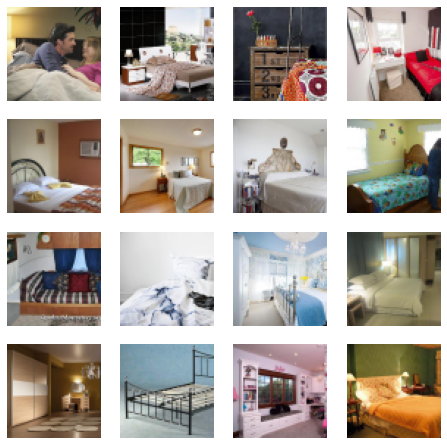

In [ ]:
dl = DataLoader(tds, batch_size=16, num_workers=fc.defaults.cpus)
(xb,) = next(iter(dl))
show_images(xb+0.5, imsize=2)

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[0])

In [ ]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [ ]:
(xt,t),eps = b = next(iter(dls.train))

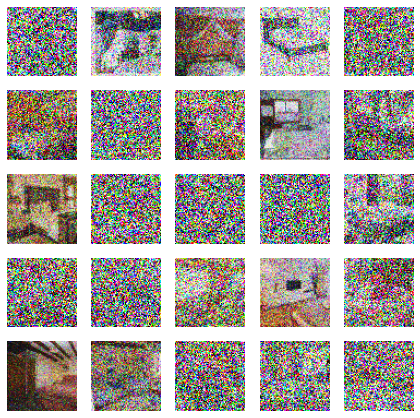

In [ ]:
show_images((xt[:25]*5).sigmoid(), imsize=1.5)

In [ ]:
class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [ ]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=3, out_channels=3, nfs=(64,128,256,512), num_layers=2, attn_chans=8, attn_start=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.070,0,train
0.047,0,eval
0.043,1,train
0.042,1,eval
0.037,2,train
0.035,2,eval
0.034,3,train
0.035,3,eval
0.033,4,train
0.034,4,eval


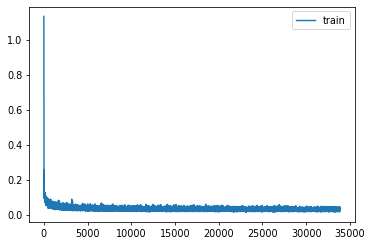

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model.state_dict(), 'models/lsun_diffusion-attn.pkl')

## Sampling

In [ ]:
sz = (64,3,64,64)

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)

In [ ]:
s = (preds[-1]+0.5)
s.min(),s.max(),s.shape

(tensor(-0.0994), tensor(1.1193), torch.Size([64, 3, 64, 64]))

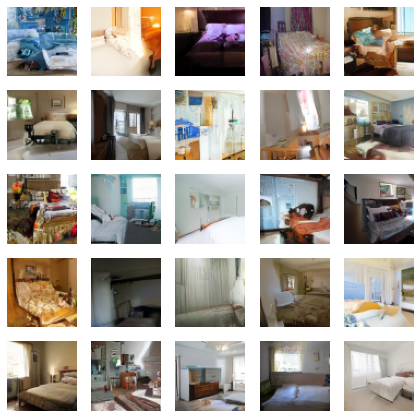

In [ ]:
show_images(s[:25].clamp(0,1), imsize=1.5)